In [59]:
import numpy as np
import re
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib2tikz import save as tikz_save
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [85]:
def get_words(doc):
    """Function to count number of words in a string."""
    words = re.findall(r'[A-Z][a-z]+|[A-Z]+|[a-z]+|', doc)
    # a single letter is not considered as a word
    words = [word for word in words if word in ['I','U','i','u'] or len(word)>1]
    #print(words)
    #count = len(words)
    return words

In [86]:
def number_count(doc):
    """Function to count number of numbers in a string."""
    words = re.findall(r'[+-]?\d+(?:\.\d+)?(?:[eE][+-]?\d+)?', doc)
    #print(words)
    count = len(words)
    return count

In [87]:
def question_mark_count(doc):
    """Function to count number of question mark in a string."""
    words = re.findall(r'\?', doc)
    #print(words)
    count = len(words)
    return count

In [88]:
def exclamation_count(doc):
    """Function to count number of exclamation mark in a string."""
    words = re.findall(r'\!', doc)
    #print(words)
    count = len(words)
    return count

In [89]:
def get_items(filename, comment=None):
    if not comment:
        #print("not comment")
        comment = ";"
    items = []
    import codecs
    with open(filename, encoding='ISO-8859-1') as file:
        for line in file:
            if line[0] == comment:
                continue
            else:
                line = ' '.join(line.split())
                items.append(line.split(" ")[0])
    # then delete duplicates if any
    #seen = set()
    #uniq = [x for x in items if x not in seen and not seen.add(x)] 
    return items

In [90]:
import subprocess
def senti_strength(text):
    cmd = ['java', '-jar', '../senti_strength/SentiStrengthCom.jar', 'sentidata', 
           '../senti_strength/SentStrength_Data/', 'text', text, 
           'sentenceCombineTot','paragraphCombineTot','maxWordsBeforeSentimentToNegate',
           '3',]
    outputs = subprocess.check_output(cmd).decode("utf-8").replace('\n','').split(" ")
    return (int(outputs[0]),int(outputs[1]))

In [91]:
# initialize array for storing data
number_data = 338
data = {"id": np.empty(number_data, dtype="int32"),
        "thread_id": np.empty(number_data, dtype="int32"),
        "sentiment": np.empty(number_data, dtype="int32"),
        "whoposts": np.empty(number_data, dtype="str"),
        "post_body": np.empty(number_data, dtype=object),
        "feature":np.empty(number_data, dtype=object)}

In [92]:
# read annotations from .csv file
import csv
file = 'data/corrected_posts_delete.csv'
with open(file) as csvfile:
    reader = csv.reader(csvfile)
    count = 0
    for row in reader:
        # exclude the first row, which are column names
        if count != 0:
            #print("Current line:",count)
            data['id'][count-1] = count
            data['thread_id'][count-1] = row[0]
            data['sentiment'][count-1] = row[1]
            data['whoposts'][count-1] = row[2]
            data['post_body'][count-1] = row[3]
        count += 1

In [93]:
def extract_feature(doc):
    num_pos = 0
    num_neg = 0
    num_slang = 0
    words = get_words(doc)
    doc_length = sum([len(word) for word in words])
    post_length = len(words)
    pos_words = get_items('lists/positive-words.txt')
    neg_words = get_items('lists/negative-words.txt')
    pos_emot = get_items('lists/positive-emoticons.txt')
    neg_emot = get_items('lists/negative-emoticons.txt')
    slang = get_items('lists/internet-slang.txt')
    #slang = [item.lower() for item in slang]
    for word in words:
        if word.lower() in pos_words:
            num_pos += 1
        elif word.lower() in neg_words:
            num_neg += 1
        else:
            continue
    doc = ' '.join(doc.split())
    any_words = doc.split(" ")
    for word in any_words:
        if word in pos_emot:
            #print(word)
            num_pos += 1
        elif word in neg_emot:
            #print(word)
            num_neg += 1
        elif word in slang:
            #print(word)
            num_slang += 1
        else:
            continue
    pos_strength, neg_strength = senti_strength(doc)
    if neg_strength != 0:
        pos_vs_neg_strength = pos_strength/neg_strength
    else:
        pos_vs_neg_strength = -pos_strength
    return {"pos":num_pos/post_length, "neg":num_neg/post_length, "num_slang":num_slang,
           "pos_vs_neg": (num_pos+1)/(num_neg+1), "avg_word_len": doc_length/len(words),
           "exclamation": exclamation_count(doc), "question_mark": question_mark_count(doc),
            "pos_strength": pos_strength,"neg_strength":neg_strength,
            "pos_vs_neg_strength": pos_vs_neg_strength, "number_number":number_count(doc)
           }

In [94]:
for i in range(4):
    feature = extract_feature(data['post_body'][i])
    print(feature.values())
    

dict_values([4.608695652173913, 0.0, 2, -5, 4, -0.0, 0, 1, 0, 0.057971014492753624, 0.2])
dict_values([4.042492917847025, 0.025495750708215296, 3, -26, 24, -1.2692307692307692, 33, 0, 0, 0.026912181303116147, 0.95])
dict_values([4.75, 0.07894736842105263, 0, -2, 1, -2.5, 5, 0, 0, 0.02631578947368421, 2.3333333333333335])
dict_values([4.245901639344262, 0.0, 0, 0, 1, 0, 0, 0, 0, 0.01639344262295082, 0.5])


In [95]:
for idx in range(number_data):
    data['feature'][idx] = extract_feature(data['post_body'][idx])

In [96]:
import pickle
def save_obj(obj, name ):
    with open('data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [97]:
save_obj(data, 'posts_training_data')

In [98]:
data = load_obj('posts_training_data')

In [99]:
def get_accuracy(predictions, gt):
    return np.sum(predictions==gt)/len(gt)

In [100]:
features = np.array([list(feature.values()) for feature in data['feature']])
target = data['sentiment']
print(features.shape)

(338, 11)


In [101]:
# get indexes of positive sentiment
pos_idx = np.where(data['sentiment']==1)
neg_idx = np.where(data['sentiment']==0)

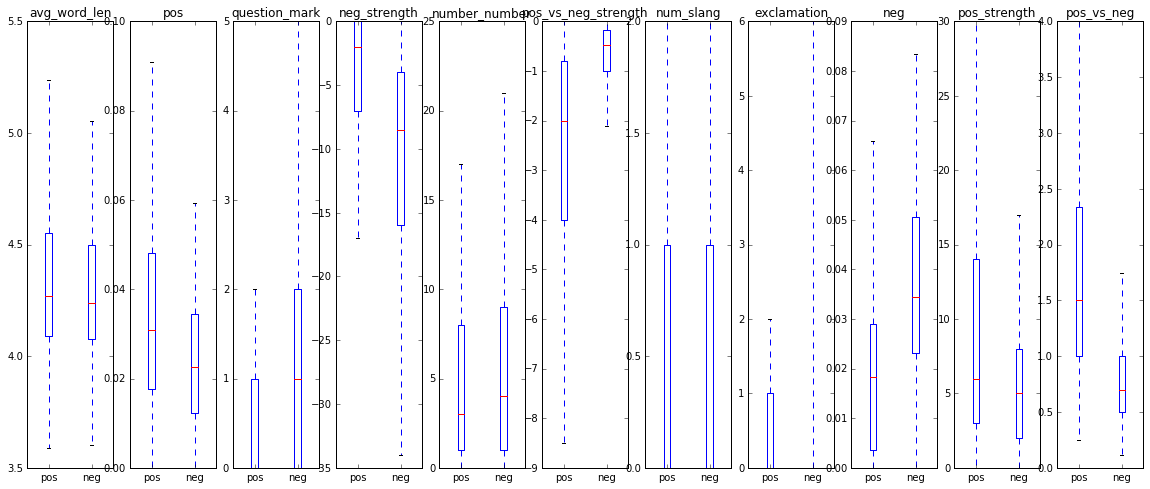

In [113]:
keys = data['feature'][0].keys()
features_dict = dict()
for key in keys:
    features_dict[key] = np.array([feature[key] for feature in data['feature']])
total_plots = len(features_dict)
current_plot = 0
f, axarr = plt.subplots(1,total_plots)
for (key,value) in features_dict.items():
    value_for_pos = value[pos_idx]
    value_for_neg = value[neg_idx]
    value_for_plot = [value_for_pos, value_for_neg]
    axarr[current_plot].boxplot(value_for_plot,0,'',labels=['pos','neg'])
    axarr[current_plot].set_title(key)
    current_plot += 1

In [112]:
m = features_dict['exclamation'][neg_idx]
m.sort()
m

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 6])

### Adaboost

In [65]:
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#clf = AdaBoostClassifier(n_estimators=1000)

# Create and fit an AdaBoosted decision tree
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(features, target)
predictions = bdt.predict(features)
accuracy = get_accuracy(predictions, target)
print(accuracy)
print(bdt.score(features, data['sentiment']))
predictions_prob = bdt.predict_proba(features)
#print(predictions_prob)

1.0
1.0


In [83]:
ab_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                            algorithm="SAMME",
                            n_estimators=1000)
scores = cross_val_score(ab_clf, features, target, cv=10)
print(scores)
print("Best accuracy is:", max(scores))
print("Avarage accuracy is:",scores.mean())

[ 0.79411765  0.67647059  0.70588235  0.58823529  0.76470588  0.61764706
  0.76470588  0.70588235  0.72727273  0.81818182]
Best accuracy is: 0.818181818182
Avarage accuracy is: 0.716310160428


### SVM

In [130]:
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing

scaled_features = preprocessing.scale(features)
Cs = np.logspace(-1, 2, 10)
gammas = [0.001, 0.0001]
#Cs = [1,2]
svc = svm.SVC()
#svm_clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),
#                   n_jobs=-1, cv=10,scoring='roc_auc')
svm_clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),
                   n_jobs=-1, cv=10,scoring='roc_auc')
svm_clf.fit(scaled_features, target) 
print(svm_clf.best_score_)
print(svm_clf.scorer_)
for score in svm_clf.grid_scores_:
    print(score[1])
    #print(str(score[2]))
print(svm_clf.grid_scores_)
print(svm_clf.best_params_)
#predictions = svm_clf.predict(features)
#accuracy = get_accuracy(predictions, target)
#print(accuracy)

0.841591347509
make_scorer(roc_auc_score, needs_threshold=True)
0.841591347509
0.840835446605
0.841203914429
0.834902030908
0.81700695754
0.802522920866
0.783286732991
0.77136300583
0.767215033487
0.740211218762
[mean: 0.84159, std: 0.03676, params: {'C': 0.10000000000000001}, mean: 0.84084, std: 0.03945, params: {'C': 0.21544346900318834}, mean: 0.84120, std: 0.03416, params: {'C': 0.46415888336127786}, mean: 0.83490, std: 0.03912, params: {'C': 1.0}, mean: 0.81701, std: 0.04239, params: {'C': 2.1544346900318834}, mean: 0.80252, std: 0.04947, params: {'C': 4.6415888336127775}, mean: 0.78329, std: 0.06523, params: {'C': 10.0}, mean: 0.77136, std: 0.07227, params: {'C': 21.544346900318821}, mean: 0.76722, std: 0.08490, params: {'C': 46.415888336127772}, mean: 0.74021, std: 0.09938, params: {'C': 100.0}]
{'C': 0.10000000000000001}


In [32]:
np.logspace(-3, 10, 10)

array([  1.00000000e-03,   2.78255940e-02,   7.74263683e-01,
         2.15443469e+01,   5.99484250e+02,   1.66810054e+04,
         4.64158883e+05,   1.29154967e+07,   3.59381366e+08,
         1.00000000e+10])

In [39]:
from sklearn.cross_validation import cross_val_score
svm_clf = svm.SVC()
scores = cross_val_score(svm_clf, scaled_features, target, cv=10)
print(scores)
print("Best accuracy is:", max(scores))
print("Avarage accuracy is:",scores.mean())

[ 0.73529412  0.76470588  0.76470588  0.76470588  0.82352941  0.73529412
  0.79411765  0.67647059  0.78787879  0.87878788]
Best accuracy is: 0.878787878788
Avarage accuracy is: 0.772549019608


In [24]:
svc

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Logistic Regression

In [77]:
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
scaled_features = preprocessing.scale(features)
lr_clf = linear_model.LogisticRegression()

lr_clf.fit(features, target)
predictions = lr_clf.predict(features)
accuracy = get_accuracy(predictions, target)
print(accuracy)

0.781065088757


In [81]:
scaled_features = preprocessing.scale(features)
lr_clf = linear_model.LogisticRegression()

lr_clf.fit(scaled_features, target)
predictions = lr_clf.predict(scaled_features)
accuracy = get_accuracy(predictions, target)
print(accuracy)

0.772189349112


In [27]:
scaled_features = preprocessing.scale(features)
Cs = np.logspace(-8, -2, 10)
lr = linear_model.LogisticRegression()
lr_clf = GridSearchCV(estimator=lr, param_grid=dict(C=Cs),
                   n_jobs=-1)
lr_clf.fit(scaled_features, target) 
print(lr_clf.best_score_)
print(lr_clf.scorer_)

NameError: name 'linear_model' is not defined

In [82]:
lr_clf = linear_model.LogisticRegression()
scores = cross_val_score(lr_clf, scaled_features, target, cv=10)
print(scores)
print("Best accuracy is:", max(scores))
print("Avarage accuracy is:",scores.mean())

[ 0.73529412  0.79411765  0.73529412  0.76470588  0.79411765  0.67647059
  0.76470588  0.70588235  0.72727273  0.87878788]
Best accuracy is: 0.878787878788
Avarage accuracy is: 0.757664884135


In [76]:
m = [1,2,3]
a = [0,1]

In [78]:
m[a]

TypeError: list indices must be integers or slices, not list

In [121]:
m =type(svc).__name__

In [122]:
m

'SVC'